In [62]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [63]:
data_ready = pd.read_csv("data_ready.csv")

In [64]:
data_ready[data_ready.select_dtypes(include=['float64']).columns] = data_ready.select_dtypes(include=['float64']).astype("float32")

In [65]:
# 70% training data, 15% validation, 15% test
train_dev, test = train_test_split(data_ready, test_size=0.15, random_state=42)
train, dev = train_test_split(train_dev, test_size=0.176, random_state=42)

In [66]:
# Step 1: Separate majority and minority classes
minority_class = train[train['5YR_SURV'] == 0]  # Adjust the condition based on your class labels
majority_class = train[train['5YR_SURV'] == 1]

# Step 2: Duplicate (oversample) the minority class
oversample_minority = minority_class.sample(n=len(majority_class), replace=True)

# Step 3: Combine the majority class with the oversampled minority class
balanced_df = pd.concat([majority_class, oversample_minority])

# Shuffle the dataset to mix up the rows
train = balanced_df.sample(frac=1).reset_index(drop=True)

In [67]:
# convert to tensors and extract labels

train_label = train.pop("5YR_SURV")
dev_label = dev.pop("5YR_SURV")
test_label = test.pop("5YR_SURV")

train_tf = tf.convert_to_tensor(train)
dev_tf = tf.convert_to_tensor(dev)
test_tf = tf.convert_to_tensor(test)

train_label_tf = tf.convert_to_tensor(train_label)
dev_label_tf = tf.convert_to_tensor(dev_label)
test_label_tf = tf.convert_to_tensor(test_label)

In [68]:
from tensorflow.keras.initializers import GlorotUniform

In [69]:
model = tf.keras.Sequential(
    [
       tf.keras.Input(shape=(214,)),
       tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001), name="L1"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001), name="L5"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001), name="L7"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001), name="L9"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(1, activation="sigmoid", name="L11") 
    ]
)

In [70]:
from tensorflow.keras import backend as K

# Sensitivity (Recall)
import tensorflow as tf
from tensorflow.keras import backend as K

# Specificity
import tensorflow.keras.backend as K

def specificity(y_true, y_pred):
    """
    param:
    y_pred - Predicted labels (binary: 0 or 1)
    y_true - True labels (binary: 0 or 1)
    
    Returns:
    Specificity score
    """
    # True negatives (TN) and False positives (FP)
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    
    # False positives (FP)
    fp = K.sum(neg_y_true * y_pred)
    
    # True negatives (TN)
    tn = K.sum(neg_y_true * neg_y_pred)
    
    # Specificity = TN / (TN + FP)
    specificity = tn / (tn + fp + K.epsilon())
    
    return specificity


In [71]:
model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=["accuracy", specificity]
)

In [73]:
history = model.fit(train_tf, train_label_tf, epochs=200, batch_size=128, validation_data = (dev_tf, dev_label_tf))

Epoch 1/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5271 - loss: 1.2675 - specificity: 0.4937 - val_accuracy: 0.6789 - val_loss: 1.0452 - val_specificity: 0.3933
Epoch 2/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5282 - loss: 1.2489 - specificity: 0.4957 - val_accuracy: 0.6466 - val_loss: 1.0586 - val_specificity: 0.3895
Epoch 3/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5397 - loss: 1.2158 - specificity: 0.4972 - val_accuracy: 0.6273 - val_loss: 1.0714 - val_specificity: 0.4027
Epoch 4/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5374 - loss: 1.2040 - specificity: 0.4976 - val_accuracy: 0.6279 - val_loss: 1.0717 - val_specificity: 0.4107
Epoch 5/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5337 - loss: 1.1965 - specificity: 0.4993 - val_accuracy: 0.6321 - val_loss: 1.0672 - val_specificity: 0.4123
Epoch 6/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5428 - loss: 1.1849 - specificity: 0.4994 - val_

In [14]:
# from sklearn.metrics import classification_report, roc_auc_score

# y_pred = model.predict(X_resampled)
# y_pred = y_pred.round()
# print("Classification Report:")
# print(classification_report(dev_label_tf, y_pred))
# print("ROC AUC Score:", roc_auc_score(dev_label_tf, y_pred))

In [74]:
from sklearn.metrics import precision_score, recall_score, f1_score


y_pred = model.predict(dev_tf)
y_pred = y_pred.round()

precision = precision_score(dev_label_tf, y_pred)
recall = recall_score(dev_label_tf, y_pred)
f1 = f1_score(dev_label_tf, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
recall_score(dev_label_tf, y_pred, pos_label=0)

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Precision: 0.76
Recall: 0.76
F1-Score: 0.76


0.4220716360116166

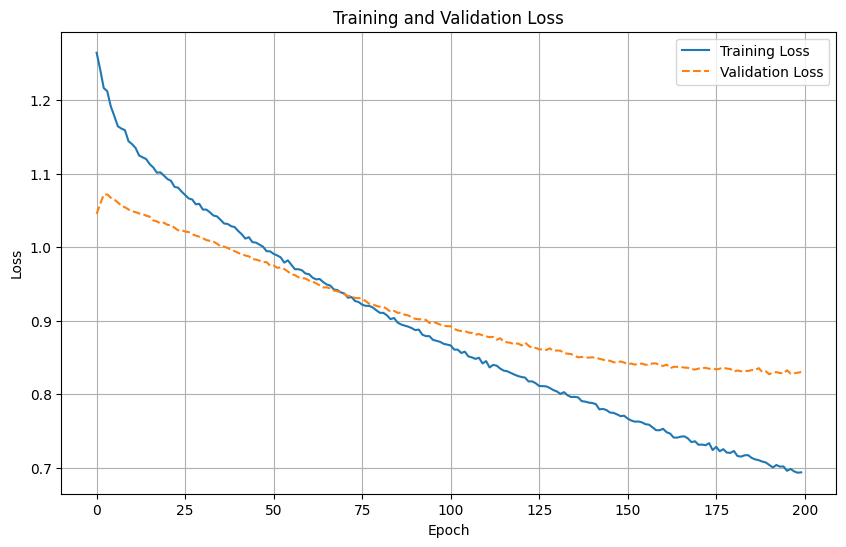

In [75]:
loss_values = history.history['loss']
val_loss_values = history.history.get('val_loss')

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
if val_loss_values:
    plt.plot(val_loss_values, label='Validation Loss', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
model.evaluate(dev_tf, dev_label_tf)

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6451 - loss: 0.7703 - specificity: 0.3573


[0.7768765687942505, 0.6426778435707092, 0.3574541211128235]

In [18]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
from xgboost import XGBClassifier

In [20]:
model = XGBClassifier(n_estimators=500, max_depth=6, subsample=0.7, colsample_bytree=0.7, learning_rate=0.1, reg_alpha=0.1, reg_lambda=1.0, scale_pos_weight=0.33, objective='binary:logistic')
model.fit(X_resampled, y_resampled)
print(model.score(train_tf, train_label_tf))
print(model.score(dev_tf, dev_label_tf))
y_pred = model.predict(dev_tf)

NameError: name 'X_resampled' is not defined

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(dev_label_tf, y_pred)
recall = recall_score(dev_label_tf, y_pred)
f1 = f1_score(dev_label_tf, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'reg_alpha': [0.01, 0.1, 1],
#     'reg_lambda': [0.01, 0.1, 1]
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
# grid_search.fit(np.array(train_tf), np.array(train_label_tf))

# print(f"Best Hyperparameters: {grid_search.best_params_}")
# print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model = LogisticRegression(max_iter=1000)
model.fit(train_tf, train_label_tf)
print(f"Logistic Regression Accuracy: {model.score(dev_tf, dev_label_tf) * 100:.2f}%")

model = RandomForestClassifier(n_estimators=100)
model.fit(train_tf, train_label_tf)
print(f"Random Forest Accuracy: {model.score(dev_tf, dev_label_tf) * 100:.2f}%")
model.predict(dev_tf)


precision = precision_score(dev_label_tf, y_pred)
recall = recall_score(dev_label_tf, y_pred)
f1 = f1_score(dev_label_tf, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
from sklearn.metrics import recall_score
recall_score(dev_label_tf, y_pred, pos_label=0)